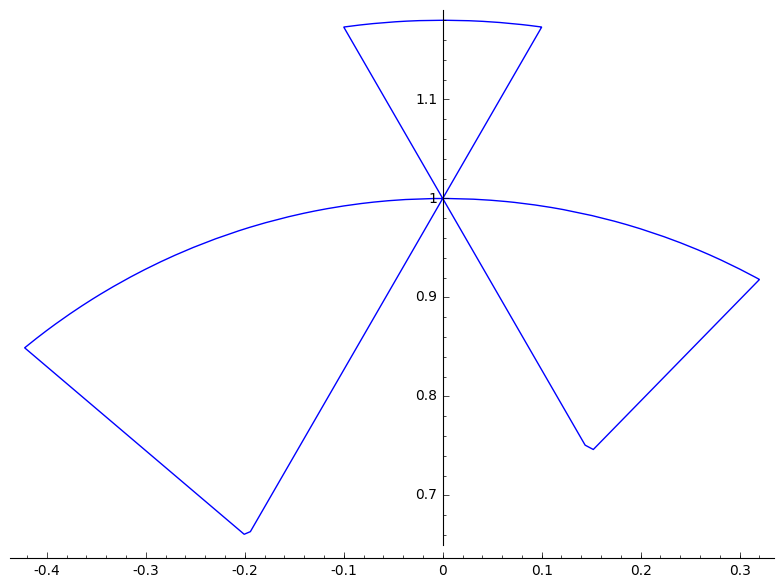

In [21]:
#M.G. 5/23/17, Most recent update 8/3/17. Major updates; too many to individually list. In general,
#significant effort has been made to generalize and simplify the code. Optimizing run-time has not
#occurred to as great a degree as desired.

t = var('t') #Global time parameter
[Ze, On, Tw] = [0, 1, 2] #Variable substitutions of integers 0, 1, and 2
#Dummy variables, utilized throughout code
dx_init, dy_init, dx_fin, dy_fin, dm, dc0, dc1, dt, dtf = var('dx_init dy_init dx_fin dy_fin dm dc0 dc1 dt dtf')

s = exp(dc1*dt) #s is defined as in section 4.1 of [Hal17]
star = var('star') #Intended as top right entry of g(s) as defined in [Hal17] section 4.1
g_temp = matrix.identity(2) + ((s-1)/(dc1^(2)*dc0*s))*matrix([[dc0 - dm, star], [1, dm - dc0*s]]) #Matrix g(s); see section 4.1 
entry01 = solve(det(g_temp) == 1, star)[0].right().full_simplify() #Value of missing entry of g(s)
gs = g_temp.substitute(star == entry01)
R = matrix([[N(cos(pi/3)), N(-sin(pi/3))], [N(sin(pi/3)), N(cos(pi/3))]]) #R as defined in [Hal17] section 3.5
R_inverse = R.inverse() # = matrix([[N(cos(-pi/3)), N(-sin(-pi/3))], [N(sin(-pi/3)), N(cos(-pi/3))]])
J = matrix([[0, -1], [1, 0]]) #J as defined in [Hal17] section 2.2
unit_circle = parametric_plot((lambda t: cos(t), lambda t: sin(t)), (t, 0, 2*pi), color = 'red') #See 'plot_comparison' below

def mobius(M, z):
    [[a, b], [c, d]] = M
    return N((a*z + b)/(c*z + d))

def linfrac(z): #Mobius transformation R.z, with R as defined in [Hal17] section 3.5
    return mobius(R, z)
    #[[a, b], [c, d]] = [[N(1/2), N(-sqrt(3)/2)], [N(sqrt(3)/2), N(1/2)]]
    #return N((a*z + b)/(c*z + d))
    
def inverse_linfrac(z):
    return mobius(R_inverse, z)
    #[[a, b], [c, d]] = [[N(1/2), N(sqrt(3)/2)], [N(-sqrt(3)/2), N(1/2)]]
    #return N((a*z + b)/(c*z + d))
    
def c0c1(z_init, m): 
    c0 = N(z_init.real() + m)
    c1 = N(z_init.imag()/c0)
    return (c0, c1)

def z_hat(z):
    return matrix([[z.imag(), z.real()], [0, 1]])

def X(z):
    return z_hat(z)*J*z_hat(z).inverse()

def e(i, z_init, t): #Inputs i = 0, 1, 2. IMPORTANT: e(i = 0) (notation e0) corresponds to e3 in [Hal17]!!
    if i != 1:
        if i == 0:
            m = N(1/sqrt(3))
        else:
            m = N(-1/sqrt(3))
        (c0, c1) = c0c1(z_init, m)
        (x, y) = (-m + c0*exp(c1*t), c0*c1*exp(c1*t))
        return N(x + y*I)
    else: #Utilize linear fractional transformation; true e1 parametrization is quite complex
        Rz_init = linfrac(z_init)
        Rz_t = e(0, Rz_init, t)
        return N(inverse_linfrac(Rz_t))

#solve(dx_fin == -dm + (dx_init + dm)*e^((dy_init/(dx_init + dm))*t), t)[0].right().full_simplify()
def compute_time(dm, dx_init, dx_fin, dy_init):
    solve_output = (dm + dx_init)*log((dm + dx_fin)/(dm + dx_init))/dy_init
    return solve_output

def get_time(z_init, z_fin): #Only for use for two points on an e2 or e3 trajectory, NOT an e1 trajectory
    if z_init.imag() <= z_fin.imag(): #if-else required to determine the sign of m
        m = N(1/sqrt(3)) 
    else:
        m = N(-1/sqrt(3))
    return compute_time(m, z_init.real(), z_fin.real(), z_init.imag())
    
#The input here should be the terminal x-point you choose after initially traveling along e3; everything is determined from here
def simple_control_trajectory(x1):
    (x0, y0) = (0, 1)
    z0 = x0 + y0*I
    y1 = N(sqrt(3)*x1 + 1)
    z1 = x1 + y1*I
    t1 = get_time(z0, z1)
    z2 = -x1 + y1*I  #By symmetry (across imaginary axis)
    t2 = get_time(linfrac(z1), linfrac(z2))
    t3 = get_time(z2, z0) #Note that t3 == t1
    return [[Ze, N(z0), N(t1)], [On, N(z1), N(t2)], [Tw, N(z2), N(t3)]] #Zero-th entry in each of the 3 3-tuples is the 'i' input for function e 

def control_trajectory(*args): #The general control trajectory, accepting 1, 2, or 3 inputs.
    if len(args) == 1:
        return simple_control_trajectory(*args)
    elif len(args) == 2: #For 2-param, be sure that x1_p is (strictly) between -sqrt(1/12) and sqrt(1/12), else line exits star region
        (x1, x1_p) = args
        [[Ze, z0, t1], [On, z1, t2], [Tw, z2, t3]] = simple_control_trajectory(x1)
        y1_p = N(-sqrt(3)*x1_p + 1); z1_p = x1_p + y1_p*I
        t1_p = get_time(z0, z1_p)
        z2_p = -x1_p + y1_p*I
        t2_p = get_time(linfrac(z1_p), linfrac(z2_p))
        t3_p = get_time(z2_p, z0)
        return [[Ze, N(z0), N(t1)], [On, N(z1), N(t2)], [Tw, N(z2), N(t3 + t1_p)], [On, N(z1_p), N(t2_p)], [Ze, N(z2_p), N(t3_p)]]
    elif len(args) == 3:
        (x1, x1_p, x1_p2) = args
        [[Ze, z0, t1], [On, z1, t2], [Tw, z2, t3]] = simple_control_trajectory(x1)
        [[Ze, z0_temp, t1_p], [On, z1_temp, t2_p], [Tw, z2_temp, t3_p]] = simple_control_trajectory(x1_p)
        [[Ze, z0_temp2, t1_p2], [On, z1_temp2, t2_p2], [Tw, z2_temp2, t3_p2]] = simple_control_trajectory(x1_p2)
        [z1_p, z2_p, z0_p] = [linfrac(z1_temp), linfrac(z2_temp), linfrac(z0_temp)]
        [z1_p2, z2_p2, z0_p2] = [inverse_linfrac(z1_temp2), inverse_linfrac(z2_temp2), inverse_linfrac(z0_temp2)]
        return [[Ze, z0, t1], [On, z1, t2], [Tw, z2, t3 + t1_p], [Ze, z1_p, t2_p], [On, z2_p, t3_p + t1_p2], [Tw, z1_p2, t2_p2], [Ze, z2_p2, t3_p2]]
    else:
        print("Enter in an appropriate number of parameters; either 1, 2, or 3. Or, edit the function however you'd like!")
        
def path(c, t):
    if c == []:
        return 0 + 1*I
    elif t <= c[0][2]:
        return e(c[0][0], c[0][1], t)
    else:
        return path(c[1:], t - c[0][2])
    
def tf(control):
    T = 0
    for i in range(0, len(control)):
        T = T + control[i][2]
    return T
        
def bar(c): #c = control_trajectory(*args)
    arr = [c[0][1]]
    for i in range(0, len(c)-1):
        arr.append(mobius(R^(c[i][0]-c[i+1][0]), e(0, arr[i], c[i][2])))
    return arr
    
#(3/2)*integral((x^(2) + y^(2) + 1)/y, t, 0, tf)    
def IF(z, tf): #IF abbreviation for 'integral formula'
    m = N(1/sqrt(3))
    (c0, c1) = c0c1(z, m)
    x = -m + c0*exp(c1*t); y = c0*c1*exp(c1*t)  #Solutions to differential equations; see (34) in [Hal17]
    integral_output = 3/2*-(m^2 - (c0^2*c1^2 + c0^2)*exp(2*c1*tf) + (c0^2*c1^2 + 2*c0*c1*m*tf + c0^2 - m^2 - 1)*exp(c1*tf) + 1)*exp(-c1*tf)/(c0*c1^2)
    #To clarify, the factor of 3/2 that appears in front of integral_output is the same 3/2 that is in
    #front of the integral itself, as given above this function, and also by (18)
    return integral_output

def cost(*args):
    c = control_trajectory(*args); b = bar(c)
    total_cost = 0
    for i in range(0, len(c)):
        total_cost += IF(b[i], c[i][2])
    return total_cost
    

#Plots not reliable for large values of tf, e.g. tf == 10; likely that parametric_plot becomes less refined (it plots over further spaced out points and approximates in between)
def plot_path(*args):
    control = control_trajectory(*args)
    t_f = tf(control)
    return parametric_plot((lambda t: path(control, t).real(), lambda t: path(control, t).imag()), (t, 0, t_f))

plot_path(0.1, 0.2, 0.3)

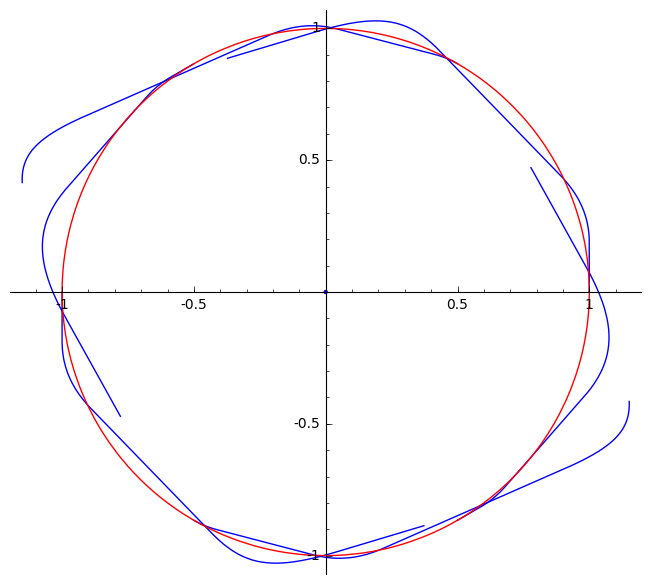

In [20]:
#gs.substitute([dt == t, dc0 == c0, dc1 == c1, dm == N(1/sqrt(3))]) is  equal to matrix([[(c0 - m)*(e^(c1*t) - 1)*e^(-c1*t)/(c0*c1^2) + 1, (c0*m - m^2 - (c0^2*c1^2 + c0^2 - c0*m)*e^(c1*t))*(e^(c1*t) - 1)*e^(-c1*t)/(c0*c1^2)], [(e^(c1*t) - 1)*e^(-c1*t)/(c0*c1^2), -(c0*e^(c1*t) - m)*(e^(c1*t) - 1)*e^(-c1*t)/(c0*c1^2) + 1]])
#where m = N(1/sqrt(3))
def gamma(i, z, t):
    (c0, c1) = c0c1(z, N(1/sqrt(3)))
    gamma0 = gs.substitute([dt == t, dc0 == c0, dc1 == c1, dm == N(1/sqrt(3))])
    return (R^i)*gamma0*(R^(-i))

def g(c, t): #c = control_trajectory(*args)
    b = bar(c); T = c[0][2]; M = identity_matrix(2); i = 0
    while t > T:
        M *= gamma(c[i][0], b[i], c[i][2])
        T += c[i+1][2]
        i += 1
    M *= gamma(c[i][0], b[i], t - (T - c[i][2]))
    return M
    
def e_star(j): #Inputs are j = 0, 1, 2, 3, 4, 5
    return vector([N(cos(2*pi*j/6)), N(sin(2*pi*j/6))])

def sigma(j, control, t):
    return g(control, t)*e_star(j)

def plot_g(i1, j1, i2, j2, *args): 
    #Not a necessary function; use if you would like to verify that (g_i1j1(t), g_i2j2(t)) is a differentiable graph (for any pair of indices)
    control = control_trajectory(*args)
    t_f = tf(control)
    return parametric_plot((lambda t: g(control, t)[i1][j1], lambda t: g(control, t)[i2][j2]), (t, 0, t_f))

def plot_sigma(j, control): #control = control_trajectory(*args)
    t_f = tf(control)
    return parametric_plot((lambda t: sigma(j, control, t)[0], lambda t: sigma(j, control, t)[1]), (t, 0, t_f))

def plot_shape(*args):
    c = control_trajectory(*args)
    P = point((0, 0))
    for j in range(0, 6):
        P = P + plot_sigma(j, c)
    return P

def plot_comparison(*args):
    return plot_shape(*args) + unit_circle

def error(*args):
    control = control_trajectory(*args)
    t_f = tf(control)
    [[a, b], [c, d]] = g(control, t_f)
    return (a - d)^(2) + (b + c)^(2)

plot_comparison(0.1, 0.2, 0.3)

In [ ]:
#These are functions that are viable (and were implemented in the program at some point), but have been
#replaced with functions that are either computationally or visually more concise. At the bottom,
#there are also many comments of computations that have been done at some point or another,
#which I may yet reference, and do not want to delete yet. However, any online users can ignore
#all of the functions, comments, etc. which appear below this point.

def e3(z_init, t):
    m = N(1/sqrt(3))
    (c0, c1) = c0c1(z_init, m)
    x = -m + c0*exp(c1*t)
    y = c0*c1*exp(c1*t)
    z = x + y*I
    return N(z)

def e2(z_init, t):
    m = N(-1/sqrt(3)); (c0, c1) = c0c1(N(z_init), m)
    x = -m + c0*exp(c1*t)
    y = c0*c1*exp(c1*t)
    z = x + y*I
    return N(z)

#Utilizing the Mobius transformation, translate points on e1 trajectory into points on e3, 
#then map back to e1; true e1 parametrization is quite complex
def e1(z_init, t): 
    Rz_init = linfrac(z_init)
    Rz_t = e3(Rz_init, t)
    return N(inverse_linfrac(Rz_t))

def generic_bar(z1, *args):
    if len(args) == 1: #args is just t2
        [t2] = args
        z1_bar = inverse_linfrac(z1)
        w = e(0, z1_bar, t2)
        z2_bar = inverse_linfrac(w)
        return [z1_bar, z2_bar]
    elif len(args) == 3: #args are t2, t3 + t1_p, and t2_p; note that the t3 + t1_p should be entered as one summed input
        [t2, t3_plus_t1_p, t2_p] = args
        z1_bar = inverse_linfrac(z1)
        w = e(0, z1_bar, t2)
        z2_bar = inverse_linfrac(w)
        v = e(0, z2_bar, t3_plus_t1_p)
        z1_p_bar = linfrac(v)
        r = e(0, z1_p_bar, t2_p)
        z2_p_bar = linfrac(r)
        return [z1_bar, z2_bar, z1_p_bar, z2_p_bar]
    elif len(args) == 5: #args are t2, t3  + t1_p, t2_p, t3_p + t1_p2, t2_p2; again note the summed input entries
        [t2, t3_plus_t1_p, t2_p, t3_p_plus_t1_p2, t2_p2] = args
        z1_bar = inverse_linfrac(z1)
        w = e(0, z1_bar, t2)
        z2_bar = inverse_linfrac(w)
        v = e(0, z2_bar, t3_plus_t1_p)
        z1_p_bar = inverse_linfrac(v)
        r = e(0, z1_p_bar, t2_p)
        z2_p_bar = inverse_linfrac(r)
        s = e(0, z2_p_bar, t3_p_plus_t1_p2)
        z1_p2_bar = inverse_linfrac(s)
        q = e(0, z1_p2_bar, t2_p2)
        z2_p2_bar = inverse_linfrac(q)
        return [z1_bar, z2_bar, z1_p_bar, z2_p_bar, z1_p2_bar, z2_p2_bar]
    else:
        print("Place a suitable number of times; appropriate options are 1, 3, or 5 inputs")
        
def generic_cost(*args):
    c = generic_control_trajectory(*args)
    z0 = 0 + 1*I; z1 = c[1][1]
    if len(args) == 1:
        [t1, t2, t3] = [c[0][2], c[1][2], c[2][2]]
        [z1_bar, z2_bar] = generic_bar(z1, t2)
        [Integral1, Integral2, Integral3] = [IF(z0, t1), IF(z1_bar, t2), IF(z2_bar, t3)]
        total_cost = Integral1 + Integral2 + Integral3
        return total_cost
    elif len(args) == 2:
        [t1, t2, t3_plus_t1_p, t2_p, t3_p] = [c[0][2], c[1][2], c[2][2], c[3][2], c[4][2]]
        [z1_bar, z2_bar, z1_p_bar, z2_p_bar] = generic_bar(z1, t2, t3_plus_t1_p, t2_p)
        [Integral1, Integral2, Integral3, Integral4, Integral5] = [IF(z0, t1), IF(z1_bar, t2), IF(z2_bar, t3_plus_t1_p), IF(z1_p_bar, t2_p), IF(z2_p_bar, t3_p)]
        total_cost = Integral1 + Integral2 + Integral3 + Integral4 + Integral5
        return total_cost
    elif len(args) == 3:
        [t1, t2, t3_plus_t1_p, t2_p, t3_p_plus_t1_p2, t2_p2, t3_p2] = [c[0][2], c[1][2], c[2][2], c[3][2], c[4][2], c[5][2], c[6][2]]
        [z1_bar, z2_bar, z1_p_bar, z2_p_bar, z1_p2_bar, z2_p2_bar] = generic_bar(z1, t2, t3_plus_t1_p, t2_p, t3_p_plus_t1_p2, t2_p2)
        [Integral1, Integral2, Integral3, Integral4, Integral5, Integral6, Integral7] = [IF(z0, t1), IF(z1_bar, t2), IF(z2_bar, t3_plus_t1_p), IF(z1_p_bar, t2_p), IF(z2_p_bar, t3_p_plus_t1_p2), IF(z1_p2_bar, t2_p2), IF(z2_p2_bar, t3_p2)]
        total_cost = Integral1 + Integral2 + Integral3 + Integral4 + Integral5 + Integral6 + Integral7
        return total_cost
    else:
        print("Enter a suitable number of paramaters; appropriate amount of inputs is 1, 2, or 3")
        
def generic_g(control, t): #Ideally, this function gets simplified, likely by recursion
    if len(control) == 3:
        [[e3, z0, t1], [e1, z1, t2], [e2, z2, t3]] = control
        t = max(t, 0) #;t = min(t, t1 + t2 + t3)
        [z1_bar, z2_bar] = generic_bar(z1, t2)
        if 0 <= t <= t1:
            return gamma(0, z0, t)
        elif t1 <= t <= t1 + t2:
            return gamma(0, z0, t1)*gamma(1, z1_bar, t - t1)
        else:
            return gamma(0, z0, t1)*gamma(1, z1_bar, t2)*gamma(2, z2_bar, t - (t1 + t2))
    elif len(control) == 5:
        [[e3, z0, t1], [e1, z1, t2], [e2, z2, t3_plus_t1_p], [e1, z1_p, t2_p], [e3, z2_p, t3_p]] = control
        t = min(t, t1 + t2 + t3_plus_t1_p + t2_p + t3_p); t = max(t, 0)
        [z1_bar, z2_bar, z1_p_bar, z2_p_bar] = generic_bar(z1, t2, t3_plus_t1_p, t2_p)
        if 0 <= t <= t1:
            return gamma(0, z0, t)
        elif t1 <= t <= t1 + t2:
            return gamma(0, z0, t1)*gamma(1, z1_bar, t - t1)
        elif t1 + t2 <= t <= t1 + t2 + t3_plus_t1_p:
            return gamma(0, z0, t1)*gamma(1, z1_bar, t2)*gamma(2, z2_bar, t - (t1 + t2))
        elif t1 + t2 + t3_plus_t1_p <= t <= t1 + t2 + t3_plus_t1_p + t2_p:
            return gamma(0, z0, t1)*gamma(1, z1_bar, t2)*gamma(2, z2_bar, t3_plus_t1_p)*gamma(1, z1_p_bar, t - (t1 + t2 + t3_plus_t1_p))
        else:
            return gamma(0, z0, t1)*gamma(1, z1_bar, t2)*gamma(2, z2_bar, t3_plus_t1_p)*gamma(1, z1_p_bar, t2_p)*gamma(0, z2_p_bar, t - (t1 + t2 + t3_plus_t1_p + t2_p))
    elif len(control) == 7:
        [[e3, z0, t1], [e1, z1, t2], [e2, z2, t3_plus_t1_p], [e3, z1_p, t2_p], [e1, z2_p, t3_p_plus_t1_p2], [e2, z1_p2, t2_p2], [e3, z2_p2, t3_p2]] = control
        [T1, T2, T1_p, T2_p, T1_p2, T2_p2, T3_p2] = [t1,t1+t2,t1+t2+t3_plus_t1_p,t1+t2+t3_plus_t1_p+t2_p,t1+t2+t3_plus_t1_p+t2_p+t3_p_plus_t1_p2,t1+t2+t3_plus_t1_p+t2_p+t3_p_plus_t1_p2+t2_p2,t1+t2+t3_plus_t1_p+t2_p+t3_p_plus_t1_p2+t2_p2+t3_p2]
        t = min(t, T3_p2); t = max(t, 0)
        [z1_bar, z2_bar, z1_p_bar, z2_p_bar, z1_p2_bar, z2_p2_bar] = generic_bar(z1, t2, t3_plus_t1_p, t2_p, t3_p_plus_t1_p2, t2_p2)
        if 0 <= t <= T1:
            return gamma(0, z0, t)
        elif T1 <= t <= T2:
            return gamma(0, z0, t1)*gamma(1, z1_bar, t - T1)
        elif T2 <= t <= T1_p:
            return gamma(0, z0, t1)*gamma(1, z1_bar, t2)*gamma(2, z2_bar, t - T2)
        elif T1_p <= t <= T2_p:
            return gamma(0, z0, t1)*gamma(1, z1_bar, t2)*gamma(2, z2_bar, t3_plus_t1_p)*gamma(0, z1_p_bar, t - T1_p)
        elif T2_p <= t <= T1_p2:
            return gamma(0, z0, t1)*gamma(1, z1_bar, t2)*gamma(2, z2_bar, t3_plus_t1_p)*gamma(0, z1_p_bar, t2_p)*gamma(1, z2_p_bar, t - T2_p)
        elif T1_p2 <= t <= T2_p2:
            return gamma(0, z0, t1)*gamma(1, z1_bar, t2)*gamma(2, z2_bar, t3_plus_t1_p)*gamma(0, z1_p_bar, t2_p)*gamma(1, z2_p_bar, t3_p_plus_t1_p2)*gamma(2, z1_p2_bar, t - T1_p2)
        else:
            return gamma(0, z0, t1)*gamma(1, z1_bar, t2)*gamma(2, z2_bar, t3_plus_t1_p)*gamma(0, z1_p_bar, t2_p)*gamma(1, z2_p_bar, t3_p_plus_t1_p2)*gamma(2, z1_p2_bar, t2_p2)*gamma(0, z2_p2_bar, t - T2_p2)
    else:
        print("Input an appropriate control, in the desired format")


#a = 0.1; b = N(sqrt(3)*a + 1); c = a + b*I; d = -a + b*I
#c_bar = inverse_linfrac(c); d_bar = linfrac(d)
#for i in range(0, 1000):
#    print(z1(0, 1, i/1000))

#parametric_plot((lambda t: e1(a, 3, t).real(), lambda t: e1(a, 3, t).imag()), (t, 0, .2))
#print(control_trajectory(0.1))
#parametric_plot((lambda t: e3(0.1, 3, t).real(), lambda t: e3(0.1, 3, t).imag()), (t, 0, .2))
#control_trajectory(0.1)
#for i in range(0, 1000):
#    print(N(get_time(0, 1, i, sqrt(3)*i + 1, t)[0].right()))
#def function():
#    for i in range(1, 5):
#        print(control_trajectory(i))
        
#timeit('cost(0.1)')
#get_time(0, 1, 0.1, y(0.1))
#control_trajectory(0.1)
#cost(0.1)

#plot_total_path(0.1, 0.03, 2)

#cost(0.3059)
#IF(N(1/sqrt(3)), 0 + 1*I, 0.1)

#time2 = control_trajectory(0.1)[3]
#z_1 = control_trajectory(0.1)[0]
#z_2 = control_trajectory(0.1)[2]
#loc = e3(inverse_linfrac(z_1), time2)
#otherloc = inverse_linfrac(z_2)
#print(loc); print(otherloc)
#print(control_trajectory(0.1))
#plot_path_left(0.1, 1)
#plot_path_right(0.1, 1)
#plot_path_upside_down(0.1, 1)
#plot_path2(0.1, 0.05, 1)
#new_plot_path2(0.1, 0.05, 1) + plot_path2(0.1, 0.05, 1)
#plot_path3(0.1, 0.25, -0.02, 3)
#plot_path3(0.1, 0.2, 0.04, 2)
#plot_generic_path(2, 0.1)
#new_plot_path3(0.1, 0.2, 0.04, 2, 2, 2)

#new_control_trajectory_right(0.1)

#x1 = 0.1; y1 = -N(sqrt(3))*x1 + 1; z1 = x1 + y1*I
#z1_tilde = inverse_linfrac(z1)
#z0 = 0 + 1*I
#t1 = get_time(z0, z1); t1_tilde = get_time(z0, z1_tilde)
#print(N(t1)); print(N(t1_tilde)) These two numbers are the same; t1 = t1_tilde
a = generic_control_trajectory(0.1, 0.2, 0.3)
b = generic_bar(a[1][1], a[1][2], a[2][2], a[3][2], a[4][2], a[5][2])
#timeit('barray(a)')
c = N_bar(a)
b2 = [c[0]] + b
an = [b2, c]
#generic_cost(0.1, 0.2, 0.3)
N_cost(0.1, 0.2, 0.3)



#plot_generic_comparison(3, 0.1, 0.2, 0.04)
#for i in range (0, 20):
#    print(symmetry_error(0.3*i/20))
    
    

#sigma(0, control_trajectory(0.1), 1)
#plot_sigma(0, control_trajectory(0.1), 1)
#control_temp = control_trajectory(0.1)
#g(control_temp, 1)
#parametric_plot((lambda t: g(control_temp, t)[0][0], lambda t: g(control_temp, t)[0][1]), (t, 0, 3))
#plot_g(0.1, 1)
#print(X(a, b))
#print(R*X(bar.real(), bar.imag())*R_inverse)

#d1 = R*z_hat(c_bar)*J*z_hat(c_bar).inverse()*R_inverse
#f1 = z_hat(linfrac(c_bar))*J*z_hat(linfrac(c_bar)).inverse()
#print(d1); print(f1)
#d2 = R*z_hat(c_bar)
#f2 = z_hat(linfrac(c_bar))
#print(d2); print(f2)

#[z1, t2, t3, t1_p, t2_p, t3_p, t1_p2, t2_p2] = [1 + 2*I, 0.9, 0.2, 0.1, 0.2, 2.3, 1.6, 0.34]
#print(gamma(4, z, t)); print(gamma1(z, t))
#print(bar(z1, t2)); print(generic_bar(z1, t2))

#print(error2(0.2, 0.1)); print(generic_error(0.2, 0.1))
#print(g(control_trajectory(0.1), 1)[0]); print(g(control_trajectory(0.1), 1)[1])
#sigma(0, control_trajectory(0.1), 1)
#g(control_trajectory(0.1), 1)
#plot_g(0.1, 1, 0, 0, 0, 1)
#x1 = var('x1')
#plot(lambda x1: error(x1), (x1, 0, N(1/sqrt(3)) - N(1/10000)))

#for i in range(6100, 10000):
#    if error(i/20000) < 0.003:
#        print([error(i/20000), N(i/20000)])


#z0 = 0 + 1*I
#for i in range(0, 10):
#    a = total_control(i/ 20, i/20)
#    b = a[0][1]; c = a[1][1]
#    print([(b + c)/2, i])
#print(e3(z0, 0.1))
#print(e2(z0, 0.1))
#total_control(0.1, 0.1)

#plot_shape(0.1, 1)
#plot_comparison(0.3059, 1)
#c = control_trajectory(0.075)
#(x, y) = sigma(2, c, c[1] + c[3] + c[5])
#x^2 + y^2

#cost(0.3059)

#[z1, t1, z2, t2, z3, t3] = control_trajectory(0.1)
#V1 = [e3(z3, t1), e2(z3, t1)]
#V2 = [z1, inverse_linfrac(z1)]
#print(V1); print(V2)

#z0 = 0 + 1*I
#x1_p = 0.1; y1_p = N(-sqrt(3)*x1_p + 1); z1_p = x1_p + y1_p*I
#t1_p = get_time(z0, z1_p)
#print(e3(z0, t1_p)); print(inverse_linfrac(z1_p))

#plot_path_right(0.1, 1)
#plot_comparison2(0.1, 0.1, 1)

#plot_comparison3(0.1, 0.2, 0.04, 2)

#minimize(lambda x: error(x), [0.1])
#float(error(-5))
#aa = generic_g(generic_control_trajectory(0.), .0922 + .04)
#bb = generic_g(generic_control_trajectory(0.), .0922 + .07)
#cc = generic_g(generic_control_trajectory(0.), .0922 + .07 + .0922 + .04)
#print(aa*bb); print(cc)
#[[en1a, en2a], [en3a, en4a]] = aa
#[[en1b, en2b], [en3b, en4b]] = bb
#[[en1c, en2c], [en3c, en4c]] = cc
#at = matrix([[arccos(en1a), -arcsin(en2a)], [arcsin(en3a), arccos(en4a)]])
#bt = matrix([[arccos(en1b), -arcsin(en2b)], [arcsin(en3b), arccos(en4b)]])
#ct = matrix([[arccos(en1c), -arcsin(en2c)], [arcsin(en3c), arccos(en4c)]])
#print(at); print(bt); print(ct)

#plot_generic_comparison(0.1, 0.2, 0.04)
#generic_error(0.1)
#plot_generic_comparison(0.01, 0.2)
#generic_error(0.01, 0.2)
#minimize(error, [0.1])

#timeit('generic_g(generic_control_trajectory(0.1, 0.2, 0.3), 0.1)')
#timeit('N_g(generic_control_trajectory(0.1, 0.2, 0.3), 0.1)')

In [5]:
#This cell contains old (and in all likelihood, useless), functions that were at one point implemented
#in the program (other methods have since been deleted). All of this should (and likely will) be
#deleted in the near future.

t = var('t') #Global time parameter
dx_init, dy_init, dx_fin, dm = var('dx_init dy_init dx_fin dm')
time_formula2 = solve(dx_fin == -dm + (dx_init + dm)*exp(t), t)
time_formula = solve(dx_fin == -dm + (dx_init + dm)*exp((dy_init/(dx_init + dm))*t), t)[0].right().full_simplify()
#print(t, dx_init, dy_init, dx_fin, dm)
time_formula
def old_path_left(c, t): #c = control_trajectory_left(x1)
    [z1, t1, z2, t2, z3, t3] = c
    if 0 <= t <= t1:
        return e1(z3, t) # == e1(z3, t)
    elif t1 < t < t1 + t2:
        return e2(z1, t - t1) # == e3(z1, t - t1)
    elif t1 + t2 <= t <= t1 + t2 + t3:
        return e3(z2, t - (t1 + t2)) # == e2(z2, t - (t1 + t2))
    else:
        return 0 + 1*I
    

    
    
#The input here should be the terminal x-point you choose after initially traveling along e2
def control_trajectory_upside_down(x1):
    x0 = 0; y0 = 1
    z0 = x0 + y0*I
    y1 = N(-sqrt(3)*x1 + 1)
    z1 = x1 + y1*I
    t1 = get_time(z0, z1)
    x2 = -x1; y2 = y1 #By symmetry again
    z2 = x2 + y2*I
    Rz1 = linfrac(z1)
    Rz2 = linfrac(z2)
    t2 = get_time(Rz1, Rz2)
    z3 = z0 #Notational convenience; there is no fundamental difference between z3 and z0
    t3 = get_time(z2, z3) #Note that t3 == t1 (again)
    sol = [N(z1), N(t1), N(z2), N(t2), N(z3), N(t3)] #It takes time ti to get from z(i-1) to zi, i = 1, 2, 3
    return sol

def control_trajectory_right(x1):
    [[e3, z3, t1], [e1, z1, t2], [e2, z2, t3]] = control_trajectory(x1)
    [Rz1, Rz2, Rz3] = [linfrac(z1), linfrac(z2), linfrac(z3)]
    return [[e2, N(Rz3), N(t1)], [e3, N(Rz1), N(t2)], [e1, N(Rz2), N(t3)]]
    #(x0, y0) = (0, 1); z0 = x0 + y0*I
    #y1 = N(-sqrt(3)*x1 + 1)
    #z1 = x1 + y1*I
    #t1 = get_time(z0, z1)
    #z1_tilde = inverse_linfrac(z1)
    #z2_tilde = -z1_tilde.real() + z1_tilde.imag()*I
    #z2 = linfrac(z2_tilde)
    #t2 = get_time(z1, z2)
    #z3 = z0
    #t3 = get_time(z2, z3)
    #return [N(z1), N(t1), N(z2), N(t2), N(z3), N(t3)]

def control_trajectory_left(x1):
    [[e3, z3, t1], [e1, z1, t2], [e2, z2, t3]] = control_trajectory(x1)
    [R2z1, R2z2, R2z3] = [inverse_linfrac(z1), inverse_linfrac(z2), inverse_linfrac(z3)]
    return [[e1, N(R2z3), N(t1)], [e2, N(R2z1), N(t2)], [e3, N(R2z2), N(t3)]]
    #(x0, y0) = (0, 1); z0 = x0 + y0*I
    #How do we acquire y1 from x1? (We are on an e1 trajectory). For e1, y(t) is very complicated
    #and there is no obvious linear connection between x and y (although there might be).
    

def control_trajectory2(x1, x1_p): #Now we have two degrees of freedom to work with
    return [simple_control_trajectory(x1), control_trajectory_upside_down(x1_p)]

def new_control_trajectory2(x1, x1_p):
    [[e3, z3, t1], [e1, z1, t2], [e2, z2, t3]] = control_trajectory(x1)
    y1_p = -N(sqrt(3))*x1_p + 1; z1_p = x1_p + y1_p*I
    t1_p = get_time(z3, z1_p)
    z2_p = -x1_p + y1_p*I
    t2_p = get_time(linfrac(z1_p), linfrac(z2_p))
    t3_p = get_time(z2_p, z3)
    return [[e3, N(z3), N(t1)], [e1, N(z1), N(t2)], [e2, N(z2), N(t3 + t1_p)], [e1, N(z1_p), N(t2_p)], [e3, N(z2_p), N(t3_p)]]


def control_trajectory3(x1, x1_p, x1_p2): #3 d.f. and capturing hyperbolic symmetry as well
    return [control_trajectory(x1), new_control_trajectory_right(x1_p), new_control_trajectory_left(x1_p2)]

def new_control_trajectory3(x1, x1_p, x1_p2):
    [[e3, z3, t1], [e1, z1, t2], [e2, z2, t3]] = simple_control_trajectory(x1)
    [[e3, z3_temp, t1_p], [e1, z1_temp, t2_p], [e2, z2_temp, t3_p]] = simple_control_trajectory(x1_p)
    [z1_p, z2_p, z3_p] = [linfrac(z1_temp), linfrac(z2_temp), linfrac(z3_temp)]
    [[e3, z3_temp2, t1_p2], [e1, z1_temp2, t2_p2], [e2, z2_temp2, t3_p2]] = simple_control_trajectory(x1_p2)
    [z1_p2, z2_p2, z3_p2] = [inverse_linfrac(z1_temp2), inverse_linfrac(z2_temp2), inverse_linfrac(z3_temp2)]
    return [[e3, z3, t1], [e1, z1, t2], [e2, z2, t3 + t1_p], [e3, z1_p, t2_p], [e1, z2_p, t3_p + t1_p2], [e2, z1_p2, t2_p2], [e3, z2_p2, t3_p2]]

def path_upside_down(c, t): #c = control_trajectory_upside_down(x1)
    [z1, t1, z2, t2, z3, t3] = c
    if 0 <= t <= t1:
        return e2(z3, t)
    elif t1 < t < t1 + t2:
        return e1(z1, t - t1)
    elif t1 + t2 <= t <= t1 + t2 + t3:
        return e3(z2, t - (t1 + t2))
    else:
        return 0 + 1*I
    
def path_right(c, t): #c = control_trajectory(x1) NOT control_trajectory_right(x1)!!
    return linfrac(path(c, t))

#def new_path_right(c, t):
#    [z1, t1, z2, t2, z3, t3] = c
#    if 0 <= t <= t1:
#        return e2(z3, t)
#    elif t1 < t < t1 + t2:
#        return e3(z1, t - t1)
#    elif t1 + t2 <= t <= t1 + t2 + t3:
#        return e1(z2, t - (t1 + t2))
#    else:
#        return 0 + 1*I
      

def path_left(c, t): #Again, c = control_trajectory(x1)
    return inverse_linfrac(path(c, t))
    
def path2(c, t): #c = control_trajectory2(x1, x1_p)
    [z1, t1, z2, t2, z3, t3] = c[0]; [z1_p, t1_p, z2_p, t2_p, z3_p, t3_p] = c[1]
    if 0 <= t <= t1:
        return e3(z3, t)
    elif t1 < t < t1 + t2:
        return e1(z1, t - t1)
    elif t1 + t2 <= t <= t1 + t2 + t3 + t1_p:
        return e2(z2, t - (t1 + t2))
    elif t1 + t2 + t3 + t1_p <= t <= t1 + t2 + t3 + t1_p + t2_p:
        return e1(z1_p, t - (t1 + t2 + t3 + t1_p))
    elif t1 + t2 + t3 + t1_p + t2_p <= t <= t1 + t2 + t3 + t1_p + t2_p + t3_p:
        return e3(z2_p, t - (t1 + t2 + t3 + t1_p + t2_p))
    else:
        return 0 + 1*I
    
def path3(c, t): #c = control_trajectory3(x1, x1_p, x1_p2)
    [[z1, t1, z2, t2, z3, t3], [z1_p, t1_p, z2_p, t2_p, z3_p, t3_p], [z1_p2, t1_p2, z2_p2, t2_p2, z3_p2, t3_p2]] = c
    #Following line simply meant for concision of time notation. Capital Ts are the 'accumulation' of time up to (and including) corresponding lowercase t.
    [T1, T2, T3, T1_p, T2_p, T3_p, T1_p2, T2_p2, T3_p2] = [t1,t1+t2,t1+t2+t3,t1+t2+t3+t1_p,t1+t2+t3+t1_p+t2_p,t1+t2+t3+t1_p+t2_p+t3_p,t1+t2+t3+t1_p+t2_p+t3_p+t1_p2,t1+t2+t3+t1_p+t2_p+t3_p+t1_p2+t2_p2,t1+t2+t3+t1_p+t2_p+t3_p+t1_p2+t2_p2+t3_p2]
    if 0 <= t <= T1:
        return e3(z3, t)
    elif T1 <= t <= T2:
        return e1(z1, t - T1)
    elif T2 <= t <= T1_p:
        return e2(z2, t - T2)
    elif T1_p <= t <= T2_p:
        return e3(z1_p, t - T1_p)
    elif T2_p <= t <= T1_p2:
        return e1(z2_p, t - T2_p)
    elif T1_p2 <= t <= T2_p2:
        return e2(z1_p2, t - T1_p2)
    elif T2_p2 <= t <= T3_p2:
        return e3(z2_p2, t - T2_p2)
    else:
        return 0 + 1*I    
    
def bar(z1, t2): #Only used for obtaining z1_bar and z2_bar, not z3_bar; not implemented yet
    z1_bar = inverse_linfrac(z1)
    w = e3(z1_bar, t2)
    z2_bar = inverse_linfrac(w)
    return [z1_bar, z2_bar]
        
def bar2(z1, t2, t3, t1_p, t2_p):
    z1_bar = inverse_linfrac(z1)
    w = e3(z1_bar, t2)
    z2_bar = inverse_linfrac(w)
    v = e3(z2_bar, t3 + t1_p)
    z1_p_bar = linfrac(v)
    r = e3(z1_p_bar, t2_p)
    z2_p_bar = linfrac(r)
    return [z1_bar, z2_bar, z1_p_bar, z2_p_bar]

def bar3(z1, t2, t3_plus_t1_p, t2_p, t3_p_plus_t1_p2, t2_p2):
    z1_bar = inverse_linfrac(z1)
    w = e3(z1_bar, t2)
    z2_bar = inverse_linfrac(w)
    v = e3(z2_bar, t3_plus_t1_p)
    z1_p_bar = inverse_linfrac(v)
    r = e3(z1_p_bar, t2_p)
    z2_p_bar = inverse_linfrac(r)
    s = e3(z2_p_bar, t3_p_plus_t1_p2)
    z1_p2_bar = inverse_linfrac(s)
    q = e3(z1_p2_bar, t2_p2)
    z2_p2_bar = inverse_linfrac(q)
    return [z1_bar, z2_bar, z1_p_bar, z2_p_bar, z1_p2_bar, z2_p2_bar]

def old_plot_path(x1, tf): 
    #tf = max(0, tf)
    control = control_trajectory(x1)
    return parametric_plot((lambda t: path(control, t).real(), lambda t: path(control, t).imag()), (t, 0, tf))

def plot_path_upside_down(x1, tf): 
    tf = max(0, tf)
    control = control_trajectory_upside_down(x1)
    return parametric_plot((lambda t: path_upside_down(control, t).real(), lambda t: path_upside_down(control, t).imag()), (t, 0, tf))

def plot_path_right(x1, tf):
    control = control_trajectory(x1)
    return parametric_plot((lambda t: path_right(control, t).real(), lambda t: path_right(control, t).imag()), (t, 0, tf))

def plot_path_left(x1, tf):
    control = control_trajectory(x1)
    return parametric_plot((lambda t: path_left(control, t).real(), lambda t: path_left(control, t).imag()), (t, 0, tf))

def plot_path2(x1, x1_prime, tf):
    tf = max(0, tf)
    control = control_trajectory2(x1, x1_prime)
    return parametric_plot((lambda t: path2(control, t).real(), lambda t: path2(control, t).imag()), (t, 0, tf))

def new_plot_path2(x1, x1_prime, tf1, tf2): #Which plot_path2 is faster?
    return plot_path(x1, tf1) + plot_path_upside_down(x1_prime, tf2)

def plot_path3(x1, x1_prime, x1_prime2, tf):
    tf = max(0, tf)
    control = control_trajectory3(x1, x1_prime, x1_prime2)
    return parametric_plot((lambda t: path3(control, t).real(), lambda t: path3(control, t).imag()), (t, 0, tf))
    
def new_plot_path3(x1, x1_prime, x1_prime2, tf1, tf2, tf3): #Which plot_path3 is faster?
    return plot_path(x1, tf1) + plot_path_right(x1_prime, tf2) + plot_path_left(x1_prime2, tf3)

def old_cost(x1):
    [[e3, z3, t1], [e1, z1, t2], [e2, z2, t3]] = simple_control_trajectory(x1)
    z1_bar = inverse_linfrac(z1)
    w = e3(z1_bar, t2)
    z2_bar = inverse_linfrac(w)
    Integral1 = IF(z3, t1) #Clarify values later
    Integral2 = IF(z1_bar, t2)
    Integral3 = IF(z2_bar, t3)
    total_cost = Integral1 + Integral2 + Integral3
    return total_cost

def old_path(c, t): #c = control_trajectory(x1)
    [z1, t1, z2, t2, z3, t3] = c
    if 0 <= t <= t1:
        return e3(z3, t)
    elif t1 < t < t1 + t2:
        return e1(z1, t - t1)
    elif t1 + t2 <= t <= t1 + t2 + t3:
        return e2(z2, t - (t1 + t2))
    else:
        return 0 + 1*I
    
#Output is matrix([[(c0 - m)*(e^(c1*t) - 1)*e^(-c1*t)/(c0*c1^2) + 1, (c0*m - m^2 - (c0^2*c1^2 + c0^2 - c0*m)*e^(c1*t))*(e^(c1*t) - 1)*e^(-c1*t)/(c0*c1^2)], [(e^(c1*t) - 1)*e^(-c1*t)/(c0*c1^2), -(c0*e^(c1*t) - m)*(e^(c1*t) - 1)*e^(-c1*t)/(c0*c1^2) + 1]])                                              
def gamma_0(z, t): #Somehow produces error when z has no imaginary part
    m = N(1/sqrt(3))
    (c0, c1) = c0c1(z, m)
    return gs.substitute([dt == t, dc0 == c0, dc1 == c1, dm == m])

def gamma_1(z, t):
    g = gamma_0(z, t)
    return R*g*R_inverse

def gamma_2(z, t):
    g = gamma_0(z, t)
    return R_inverse*g*R

def g(control, t): #Use for 1-parameter control; control = control_trajectory(x1)
    [z1, t1, z2, t2, z3, t3] = control
    t = min(t, t1 + t2 + t3)
    t = max(t, 0)
    [z1_bar, z2_bar] = bar(z1, t2)
    if 0 <= t <= t1:
        return gamma_0(z3, t)
    elif t1 < t < t1 + t2:
        return gamma_0(z3, t1)*gamma_1(z1_bar, t - t1)
    else:
        return gamma_0(z3, t1)*gamma_1(z1_bar, t2)*gamma_2(z2_bar, t - (t1 + t2))

def g2(control, t): #Use for 2-parameter control; control = control_trajectory2(x1, x1_p)
    [[z1, t1, z2, t2, z3, t3], [z1_p, t1_p, z2_p, t2_p, z3_p, t3_p]] = control
    t = min(t, t1 + t2 + t3 + t1_p + t2_p + t3_p); t = max(t, 0)
    [z1_bar, z2_bar, z1_p_bar, z2_p_bar] = bar2(z1, t2, t3, t1_p, t2_p)
    if 0 <= t <= t1:
        return gamma_0(z3, t)
    elif t1 < t < t1 + t2:
        return gamma_0(z3, t1)*gamma_1(z1_bar, t - t1)
    elif t1 + t2 <= t <= t1 + t2 + t3 + t1_p:
        return gamma_0(z3, t1)*gamma_1(z1_bar, t2)*gamma_2(z2_bar, t - (t1 + t2))
    elif t1 + t2 + t3 + t1_p < t < t1 + t2 + t3 + t1_p + t2_p:
        return gamma_0(z3, t1)*gamma_1(z1_bar, t2)*gamma_2(z2_bar, t3 + t1_p)*gamma_1(z1_p_bar, t - (t1 + t2 + t3 + t1_p))
    else:
        return gamma_0(z3, t1)*gamma_1(z1_bar, t2)*gamma_2(z2_bar, t3 + t1_p)*gamma_1(z1_p_bar, t2_p)*gamma_0(z2_p_bar, t - (t1 + t2 + t3 + t1_p + t2_p))

def g3(control, t):
    [[e3, z3, t1], [e1, z1, t2], [e2, z2, t3_plus_t1_p], [e3, z1_p, t2_p], [e1, z2_p, t3_p_plus_t1_p2], [e2, z1_p2, t2_p2], [e3, z2_p2, t3_p2]] = control
    [T1, T2, T1_p, T2_p, T1_p2, T2_p2, T3_p2] = [t1,t1+t2,t1+t2+t3_plus_t1_p,t1+t2+t3_plus_t1_p+t2_p,t1+t2+t3_plus_t1_p+t2_p+t3_p_plus_t1_p2,t1+t2+t3_plus_t1_p+t2_p+t3_p_plus_t1_p2+t2_p2,t1+t2+t3_plus_t1_p+t2_p+t3_p_plus_t1_p2+t2_p2+t3_p2]
    t = min(t, T3_p2); t = max(t, 0)
    [z1_bar, z2_bar, z1_p_bar, z2_p_bar, z1_p2_bar, z2_p2_bar] = bar3(z1, t2, t3_plus_t1_p, t2_p, t3_p_plus_t1_p2, t2_p2)
    if 0 <= t <= T1:
        return gamma_0(z3, t)
    elif T1 <= t <= T2:
        return gamma_0(z3, t1)*gamma_1(z1_bar, t - T1)
    elif T2 <= t <= T1_p:
        return gamma_0(z3, t1)*gamma_1(z1_bar, t2)*gamma_2(z2_bar, t - T2)
    elif T1_p <= t <= T2_p:
        return gamma_0(z3, t1)*gamma_1(z1_bar, t2)*gamma_2(z2_bar, t3_plus_t1_p)*gamma_0(z1_p_bar, t - T1_p)
    elif T2_p <= t <= T1_p2:
        return gamma_0(z3, t1)*gamma_1(z1_bar, t2)*gamma_2(z2_bar, t3_plus_t1_p)*gamma_0(z1_p_bar, t2_p)*gamma_1(z2_p_bar, t - T2_p)
    elif T1_p2 <= t <= T2_p2:
        return gamma_0(z3, t1)*gamma_1(z1_bar, t2)*gamma_2(z2_bar, t3_plus_t1_p)*gamma_0(z1_p_bar, t2_p)*gamma_1(z2_p_bar, t3_p_plus_t1_p2)*gamma_2(z1_p2_bar, t - T1_p2)
    else:
        return gamma_0(z3, t1)*gamma_1(z1_bar, t2)*gamma_2(z2_bar, t3_plus_t1_p)*gamma_0(z1_p_bar, t2_p)*gamma_1(z2_p_bar, t3_p_plus_t1_p2)*gamma_2(z1_p2_bar, t2_p2)*gamma_0(z2_p2_bar, t - T2_p2)
    
def sigma(j, control, t):
    return g(control, t)*e(j)

def sigma2(j, control, t):
    return g2(control, t)*e(j)

def sigma3(j, control, t):
    return g3(control, t)*e(j)

def plot_g(x1, tf, i1, i2, i3, i4): #The i variables are for choosing desired indices of g
    control = control_trajectory(x1)
    return parametric_plot((lambda t: g(control, t)[i1][i2], lambda t: g(control, t)[i3][i4]), (t, 0, tf))

def plot_g2(x1, x1_p, tf, i1, j1, i2, j2): #The i variables are for choosing desired indices of g2
    control = control_trajectory2(x1, x1_p)
    return parametric_plot((lambda t: g2(control, t)[i1][j1], lambda t: g2(control, t)[i2][j2]), (t, 0, tf))

def plot_g3(x1, x1_p, x1_p2, tf, i1, i2, i3, i4):
    control = control_trajectory3(x1, x1_p, x1_p2)
    return parametric_plot((lambda t: g3(control, t)[i1][i2], lambda t: g3(control, t)[i3][i4]), (t, 0, tf))

def plot_sigma(j, control, tf): #control = control_trajectory(x1)
    #control = control_trajectory(x1)
    return parametric_plot((lambda t: sigma(j, control, t)[0], lambda t: sigma(j, control, t)[1]), (t, 0, tf))

def plot_sigma2(j, control, tf): #control = control_trajectory2(x1, x1_p)
    #control = control_trajectory2(x1, x1_p)
    return parametric_plot((lambda t: sigma2(j, control, t)[0], lambda t: sigma2(j, control, t)[1]), (t, 0, tf))

def plot_sigma3(j, control, tf): #control = control_trajectory3(x1, x1_p, x1_p2)
    return parametric_plot((lambda t: sigma3(j, control, t)[0], lambda t: sigma3(j, control, t)[1]), (t, 0, tf))

def plot_shape(x1, tf): #Run-time is quite slow; ~30-40 seconds
    c = control_trajectory(x1)
    P = point((0, 0))
    for j in range(0, 6):
        P = P + plot_sigma(j, c, tf)
    return P

def plot_shape2(x1, x1_p, tf):
    c = control_trajectory2(x1, x1_p)
    P = point((0, 0))
    for j in range(0, 6):
        P = P + plot_sigma2(j, c, tf)
    return P

def plot_shape3(x1, x1_p, x1_p2, tf):
    c = control_trajectory3(x1, x1_p, x1_p2)
    P = point((0, 0))
    for j in range(0, 6):
        P = P + plot_sigma3(j, c, tf)
    return P

def plot_comparison(x1, tf):
    return plot_shape(x1, tf) + unit_circle

def plot_comparison2(x1, x1_p, tf):
    return plot_shape2(x1, x1_p, tf) + unit_circle

def plot_comparison3(x1, x1_p, x1_p2, tf):
    return plot_shape3(x1, x1_p, x1_p2, tf) + unit_circle

def error(x1): 
    [[e3, z3, t1], [e1, z1, t2], [e2, z2, t3]] = simple_control_trajectory(x1)
    tf = t1 + t2 + t3
    [[a, b], [c, d]] = g([z1, t1, z2, t2, z3, t3], tf)
    #angle = arccos(a)
    #return [(a - d)^(2) + (b + c)^(2), angle]
    return (a - d)^(2) + (b + c)^(2)

def error2(x1, x1_p):
    [[[e3, z3, t1], [e1, z1, t2], [e2, z2, t3]], [z1_p, t1_p, z2_p, t2_p, z3_p, t3_p]] = control_trajectory2(x1, x1_p)
    tf = t1 + t2 + t3 + t1_p + t2_p + t3_p
    [[a, b], [c, d]] = g2([[z1, t1, z2, t2, z3, t3], [z1_p, t1_p, z2_p, t2_p, z3_p, t3_p]], tf)
    return (a - d)^2 + (b + c)^2

def error3(x1, x1_p, x1_p2):
    ct = new_control_trajectory3(x1, x1_p, x1_p2)
    [[e3, z3, t1], [e1, z1, t2], [e2, z2, t3_plus_t1_p], [e3, z1_p, t2_p], [e1, z2_p, t3_p_plus_t1_p2], [e2, z1_p2, t2_p2], [e3, z2_p2, t3_p2]] = ct
    tf = t1 + t2 + t3_plus_t1_p + t2_p + t3_p_plus_t1_p2 + t2_p2 + t3_p2
    [[a, b], [c, d]] = g3(ct, tf)
    return (a - d)^2 + (b + c)^2

def symmetry_error(x1):
    return error3(x1, x1, x1)

#error3(0.1, 0.2, 0.04) == generic_error(0.1, 0.2, 0.04)